# Clasificacion Automatica de Tickets con NLP

### Integrantes
* Bellido Santa María José Boris (jboris.bsm@gmail.com)
* Bautista Arcani Mayra (995.mayr.995@gmail.com)
* Zapata Inturias Giovany Lucas (giovazapata666@gmail.com)

## Descripcion del Problema 

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Flujo de Trajajo a Realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling 

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [ ]:
## SpaCy and en_core_web_sm installation
#!pip install spacy

##run the following command in the console
#python -m spacy download en_core_web_sm

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, string

# Import NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import Spacy libraries
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# ==== Additions (used later in the notebook) ====
from collections import Counter

# Topic modeling
from sklearn.decomposition import NMF  # (use LDA only if you add it)

# Train/test split
from sklearn.model_selection import train_test_split

# Supervised models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics & visualization
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

# Label encoding (if your Topic column has string labels)
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading the data

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [3]:
RUTA_JSON = "_dataset/complaints.json"

with open(RUTA_JSON, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.json_normalize(data)

print("Dimensiones:", df.shape)
print("Columnas (primeras 20):", list(df.columns)[:20])
df.head()

Dimensiones: (78313, 22)
Columnas (primeras 20): ['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened']


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [4]:
#print the column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.rename(columns={
    "complaint_what_happened": "complaint",
    "_source.complaint_what_happened": "complaint"
}, inplace=True)

print("Renamed columns:")
print(df.columns.tolist())

Renamed columns:
['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', 'complaint', '_source.sub_issue', '_source.consumer_consent_provided']


In [5]:
df["complaint"] = df["complaint"].replace(r"^\s*$", np.nan, regex=True)
print("Number of NaN complaints:", df["complaint"].isna().sum())


Number of NaN complaints: 57241


In [6]:
df = df.dropna(subset=["complaint"]).reset_index(drop=True)
print("New shape after dropping blanks:", df.shape)
df.head()


New shape after dropping blanks: (21072, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,complaint,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [7]:
# Write your function here to clean the text and remove all the unnecessary elements.
CLEAN_PUNCT = re.compile(r"[{}]".format(re.escape(string.punctuation)))

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"\[.*?\]", " ", text)
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = CLEAN_PUNCT.sub(" ", text)
    text = re.sub(r"\w*\d\w*", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_basic"] = df["complaint"].astype(str).apply(clean_text)
df[["complaint", "clean_basic"]].head()

,complaint,clean_basic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xx xx and was ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xx xx however fraud...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while trying to book a xxxx xxxx tick...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...


In [8]:
# Write your function to Lemmatize the texts
nlp = en_core_web_sm.load()

KEEP_TAGS = {"NN", "NNS"}  # Sustantivos

def lemmatize_and_filter_nn(text: str) -> list:
    if not isinstance(text, str) or not text.strip():
        return []
    doc = nlp(text)
    lemmas = [
        t.lemma_.lower()
        for t in doc
        if t.is_alpha and not t.is_stop and t.tag_ in KEEP_TAGS
    ]
    return lemmas

df["lemmas_nn"] = df["clean_basic"].apply(lemmatize_and_filter_nn)
df["lemmas_nn_text"] = df["lemmas_nn"].apply(lambda x: " ".join(x))
df[["clean_basic", "lemmas_nn_text"]].head()

,clean_basic,lemmas_nn_text
0,good morning my name is xxxx xxxx and i apprec...,morning stop bank cardmember service debt veri...
1,i upgraded my xxxx xxxx card in xx xx and was ...,xxxx card agent anniversary date agent informa...
2,chase card was reported on xx xx however fraud...,card application identity consent service cred...
3,on xx xx while trying to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...
4,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...


In [9]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[["complaint", "lemmas_nn_text"]].copy()
df_clean.rename(columns={
    "complaint": "complaint_clean",
    "lemmas_nn_text": "complaint_lemmatized"
}, inplace=True)

print("Shape of df_clean:", df_clean.shape)
df_clean.head()

Shape of df_clean: (21072, 2)


,complaint_clean,complaint_lemmatized
0,Good morning my name is XXXX XXXX and I apprec...,morning stop bank cardmember service debt veri...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx card agent anniversary date agent informa...
2,Chase Card was reported on XX/XX/2019. However...,card application identity consent service cred...
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx ticket offer ticket reward card informati...
4,my grand son give me check for {$1600.00} i de...,son chase account fund chase bank account mone...


In [10]:
df_clean

,complaint_clean,complaint_lemmatized
0,Good morning my name is XXXX XXXX and I apprec...,morning stop bank cardmember service debt veri...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx card agent anniversary date agent informa...
2,Chase Card was reported on XX/XX/2019. However...,card application identity consent service cred...
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx ticket offer ticket reward card informati...
4,my grand son give me check for {$1600.00} i de...,son chase account fund chase bank account mone...
...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",xxxx credit card provider claim purchase prote...
21069,I am not familiar with XXXX pay and did not un...,xxxx pay risk consumer chase bank app chase ye...
21070,I have had flawless credit for 30 yrs. I've ha...,credit yrs chase credit card freedom problem b...


In [11]:
#Write your function to extract the POS tags 
def pos_tag(text: str):

    if not isinstance(text, str) or not text.strip():
        return []
    doc = nlp(text)
    return [(t.text, t.tag_) for t in doc if t.is_alpha]

def keep_nouns_nn(text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return ""
    doc = nlp(text)
    nouns = [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop and t.tag_ == "NN"]
    return " ".join(nouns)

df_clean["complaint_POS_removed"] = df_clean["complaint_lemmatized"].apply(keep_nouns_nn)

df_clean["pos_tags_sample"] = df_clean["complaint_lemmatized"].apply(pos_tag)

In [12]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_clean,complaint_lemmatized,complaint_POS_removed,pos_tags_sample
0,Good morning my name is XXXX XXXX and I apprec...,morning stop bank cardmember service debt veri...,morning bank cardmember service debt verificat...,"[(morning, NN), (stop, VB), (bank, NN), (cardm..."
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...,"[(xxxx, NNP), (card, NN), (agent, NN), (annive..."
2,Chase Card was reported on XX/XX/2019. However...,card application identity consent service cred...,card application identity consent service cred...,"[(card, NN), (application, NN), (identity, NN)..."
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...,"[(xxxx, NN), (ticket, NN), (offer, VBP), (tick..."
4,my grand son give me check for {$1600.00} i de...,son chase account fund chase bank account mone...,fund bank account money son money bank money s...,"[(son, NNP), (chase, NNP), (account, NNP), (fu..."
...,...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,"[(chase, NN), (card, NN), (customer, NN), (dec..."
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",xxxx credit card provider claim purchase prote...,xxxx credit card provider claim purchase prote...,"[(xxxx, NN), (credit, NN), (card, NN), (provid..."
21069,I am not familiar with XXXX pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,xxxx risk consumer chase year banking merchant...,"[(xxxx, NN), (pay, VB), (risk, NN), (consumer,..."
21070,I have had flawless credit for 30 yrs. I've ha...,credit yrs chase credit card freedom problem b...,credit chase credit card freedom problem balan...,"[(credit, NN), (yrs, NNP), (chase, NN), (credi..."


## Exploratory data analysis to get familiar with the data.

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

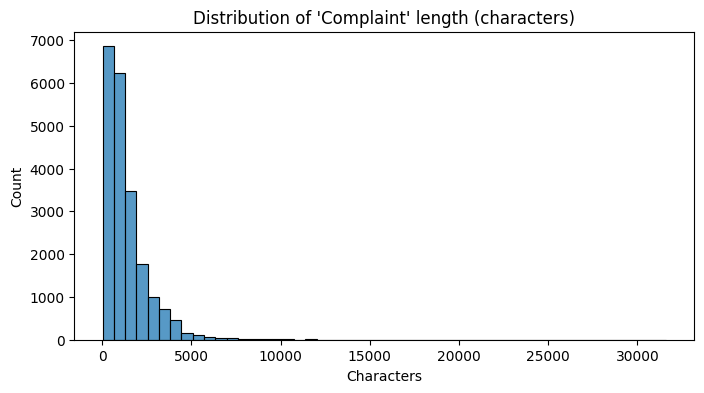

In [13]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean["complaint_len_chars"] = df_clean["complaint_clean"].astype(str).str.len()

plt.figure(figsize=(8,4))
sns.histplot(df_clean["complaint_len_chars"], bins=50)
plt.title("Distribution of 'Complaint' length (characters)")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

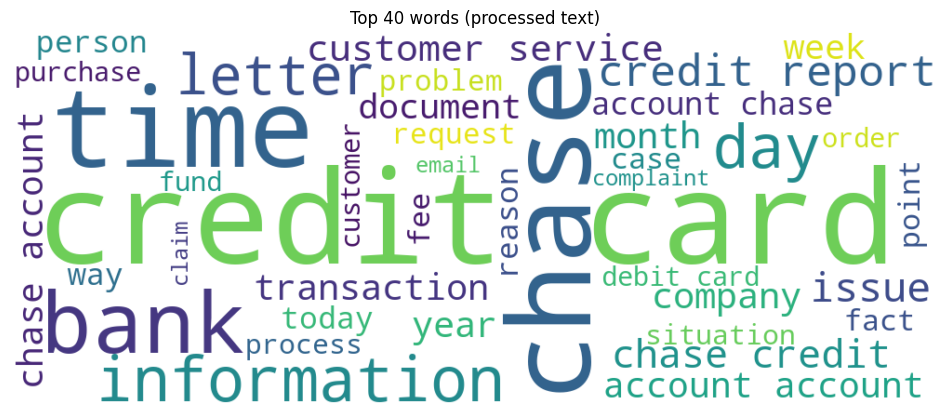

In [14]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
try:
    from wordcloud import WordCloud
    text_wc = " ".join(df_clean["complaint_POS_removed"].dropna().astype(str))
    wc = WordCloud(width=1000, height=400, max_words=40, background_color="white").generate(text_wc)
    plt.figure(figsize=(12,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Top 40 words (processed text)")
    plt.show()
except Exception as e:
    print("WordCloud not available. Install with: pip install wordcloud")
    print("Error:", e)

In [15]:
#Removing -PRON- from the text corpus
df_clean["Complaint_clean"] = df_clean["complaint_POS_removed"].str.replace("-PRON-", "", regex=False)


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [16]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def top_ngram_freq(text_series, ngram_range=(1,1), top_k=30, min_df=2, max_df=0.95):
    cv = CountVectorizer(ngram_range=ngram_range, stop_words="english", min_df=min_df, max_df=max_df)
    X = cv.fit_transform(text_series.fillna(""))
    vocab = np.array(cv.get_feature_names_out())
    freqs = np.asarray(X.sum(axis=0)).ravel()
    order = np.argsort(freqs)[::-1][:top_k]
    return pd.DataFrame({"token": vocab[order], "freq": freqs[order]})

uni_top30 = top_ngram_freq(df_clean["Complaint_clean"], (1,1), top_k=30)
display(uni_top30)
print(", ".join(uni_top30["token"].head(10)))

,token,freq
0,chase,43252
1,account,39172
2,credit,32224
3,card,29972
4,payment,21288
5,time,16090
6,day,13096
7,bank,13012
8,money,11383
9,xxxx,11301


chase, account, credit, card, payment, time, day, bank, money, xxxx


In [17]:
#Print the top 10 words in the unigram frequency
bi_top30 = top_ngram_freq(df_clean["Complaint_clean"], (2,2), top_k=30)
display(bi_top30)
print(", ".join(bi_top30["token"].head(10)))

,token,freq
0,credit card,12876
1,credit report,3757
2,customer service,2982
3,chase credit,2960
4,account account,2702
5,chase account,2663
6,account chase,2416
7,debit card,1890
8,payment payment,1822
9,card chase,1764


credit card, credit report, customer service, chase credit, account account, chase account, account chase, debit card, payment payment, card chase


In [18]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
tri_top30 = top_ngram_freq(df_clean["Complaint_clean"], (3,3), top_k=30)
display(tri_top30)
print(", ".join(tri_top30["token"].head(10)))

,token,freq
0,chase credit card,1946
1,credit card account,1025
2,credit card company,1012
3,credit card chase,816
4,credit card credit,627
5,xxxx credit card,585
6,inquiry credit report,528
7,card credit card,499
8,account credit card,468
9,credit report credit,408


chase credit card, credit card account, credit card company, credit card chase, credit card credit, xxxx credit card, inquiry credit report, card credit card, account credit card, credit report credit


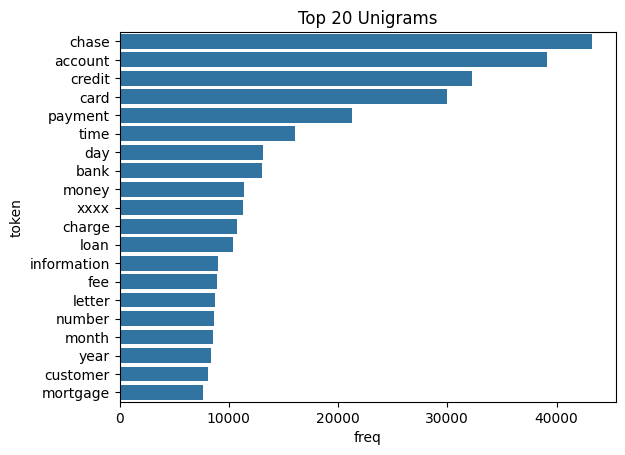

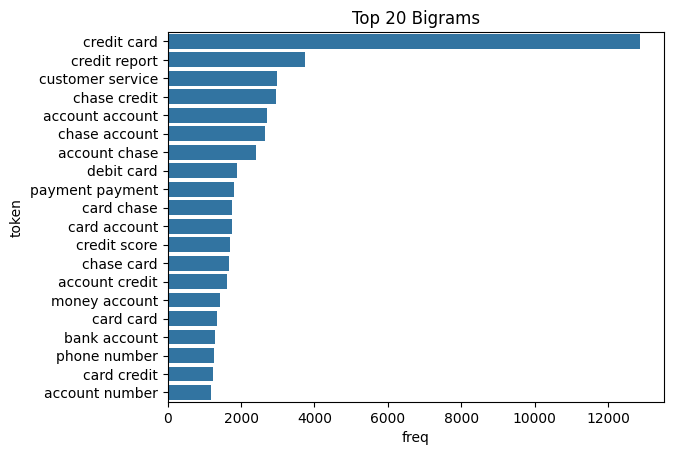

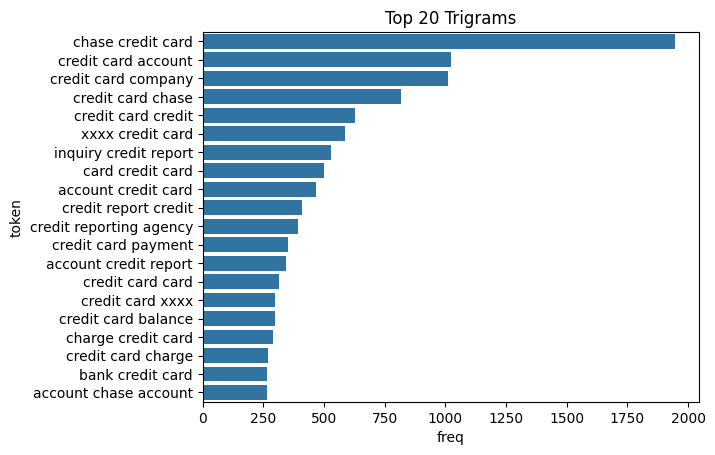

In [19]:
sns.barplot(x="freq", y="token", data=uni_top30.head(20)); plt.title("Top 20 Unigrams"); plt.show()
sns.barplot(x="freq", y="token", data=bi_top30.head(20));  plt.title("Top 20 Bigrams");  plt.show()
sns.barplot(x="freq", y="token", data=tri_top30.head(20)); plt.title("Top 20 Trigrams"); plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [20]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [21]:
#All masked texts has been removed
df_clean

,complaint_clean,complaint_lemmatized,complaint_POS_removed,pos_tags_sample,complaint_len_chars,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,morning stop bank cardmember service debt veri...,morning bank cardmember service debt verificat...,"[(morning, NN), (stop, VB), (bank, NN), (cardm...",486,morning bank cardmember service debt verificat...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...,"[(xxxx, NNP), (card, NN), (agent, NN), (annive...",355,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,card application identity consent service cred...,card application identity consent service cred...,"[(card, NN), (application, NN), (identity, NN)...",224,card application identity consent service cred...
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...,"[(xxxx, NN), (ticket, NN), (offer, VBP), (tick...",1502,ticket ticket reward card information minute ...
4,my grand son give me check for {$1600.00} i de...,son chase account fund chase bank account mone...,fund bank account money son money bank money s...,"[(son, NNP), (chase, NNP), (account, NNP), (fu...",477,fund bank account money son money bank money s...
...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,"[(chase, NN), (card, NN), (customer, NN), (dec...",679,chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",xxxx credit card provider claim purchase prote...,xxxx credit card provider claim purchase prote...,"[(xxxx, NN), (credit, NN), (card, NN), (provid...",2114,credit card provider claim purchase protectio...
21069,I am not familiar with XXXX pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,xxxx risk consumer chase year banking merchant...,"[(xxxx, NN), (pay, VB), (risk, NN), (consumer,...",2319,risk consumer chase year banking merchant mer...
21070,I have had flawless credit for 30 yrs. I've ha...,credit yrs chase credit card freedom problem b...,credit chase credit card freedom problem balan...,"[(credit, NN), (yrs, NNP), (chase, NN), (credi...",2171,credit chase credit card freedom problem balan...


## Feature Extraction
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [22]:
# Write your code here to initialise the TfidfVectorizer 
tfidf_vec = TfidfVectorizer(
    stop_words="english",
    max_df=0.95,   # ignore terms in >95% of complaints
    min_df=2,      # ignore terms appearing in <2 complaints
    ngram_range=(1,2)  # unigrams + bigrams (you can set to (1,1) if required)
)



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [23]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

corpus = df_clean["Complaint_clean"].fillna("").astype(str)

dtm = tfidf_vec.fit_transform(corpus)  
feature_names = tfidf_vec.get_feature_names_out()

print("DTM shape:", dtm.shape)          
print("Non-zero entries:", dtm.nnz)

DTM shape: (21072, 73863)
Non-zero entries: 1128219


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

Errores: {3: 141.036, 4: 140.462, 5: 140.061, 6: 139.688}
Mejor número de temas (k): 6


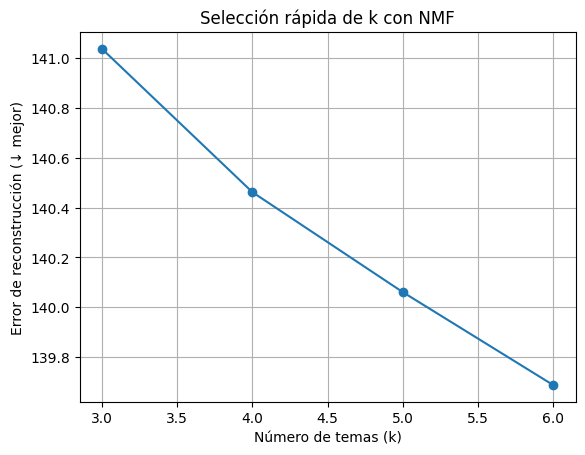

In [24]:
from sklearn.decomposition import NMF

ks = [3, 4, 5, 6]

errs = []


for k in ks:
    nmf = NMF(n_components=k, random_state=42, max_iter=10)
    nmf.fit(dtm)  # usa tu matriz TF-IDF o CountVectorizer
    errs.append(nmf.reconstruction_err_)

best_k = ks[np.argmin(errs)]
print("Errores:", dict(zip(ks, np.round(errs, 3))))
print("Mejor número de temas (k):", best_k)

plt.plot(ks, errs, marker='o')
plt.xlabel("Número de temas (k)")
plt.ylabel("Error de reconstrucción (↓ mejor)")
plt.title("Selección rápida de k con NMF")
plt.grid(True)
plt.show()

In [25]:

best_k = 5
print("Using k =", best_k)


Using k = 5


## Manual Topic Modeling
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [26]:
# Fit final NMF with best_k and create clusters
nmf_model = NMF(n_components=best_k, init="nndsvda", random_state=42, max_iter=5)
W = nmf_model.fit_transform(dtm)        # document-topic matrix
H = nmf_model.components_               # topic-term matrix


In [27]:
#Print the Top15 words for each of the topics
top_n = 15
feat = np.array(feature_names)

for t_idx, topic in enumerate(H):
    top_idx = topic.argsort()[::-1][:top_n]
    top_terms = ", ".join(feat[top_idx])
    print(f"Topic #{t_idx}: {top_terms}")


Topic #0: account, money, chase, check, fee, bank, fund, day, account account, deposit, branch, balance, transaction, customer, chase account
Topic #1: card, credit, credit card, chase credit, chase, card credit, card chase, score, card card, credit score, card account, limit, chase card, balance, card company
Topic #2: payment, mortgage, loan, payment payment, month, year, chase, balance, mortgage payment, time, chase payment, payment chase, modification, statement, credit
Topic #3: inquiry, report, credit report, credit, inquiry credit, report credit, report inquiry, credit inquiry, account, reporting, identity, credit reporting, information, company, card inquiry
Topic #4: charge, chase, dispute, loan, merchant, letter, information, time, document, fraud, company, mortgage, email, number, case


In [28]:
#Assign the best topic to each of the cmplaints in Topic Column
best_topic = W.argmax(axis=1)
df_clean["Topic"] = best_topic.astype(int)

df_clean[["Complaint_clean", "Topic"]].head()

,Complaint_clean,Topic
0,morning bank cardmember service debt verificat...,0
1,card agent anniversary date agent information ...,4
2,card application identity consent service cred...,1
3,ticket ticket reward card information minute ...,3
4,fund bank account money son money bank money s...,0


In [29]:
df_clean.head()

,complaint_clean,complaint_lemmatized,complaint_POS_removed,pos_tags_sample,complaint_len_chars,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,morning stop bank cardmember service debt veri...,morning bank cardmember service debt verificat...,"[(morning, NN), (stop, VB), (bank, NN), (cardm...",486,morning bank cardmember service debt verificat...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...,"[(xxxx, NNP), (card, NN), (agent, NN), (annive...",355,card agent anniversary date agent information ...,4
2,Chase Card was reported on XX/XX/2019. However...,card application identity consent service cred...,card application identity consent service cred...,"[(card, NN), (application, NN), (identity, NN)...",224,card application identity consent service cred...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...,"[(xxxx, NN), (ticket, NN), (offer, VBP), (tick...",1502,ticket ticket reward card information minute ...,3
4,my grand son give me check for {$1600.00} i de...,son chase account fund chase bank account mone...,fund bank account money son money bank money s...,"[(son, NNP), (chase, NNP), (account, NNP), (fu...",477,fund bank account money son money bank money s...,0


In [30]:
remap = {0: 2, 2: 0}   # <- edit or leave empty {}
if remap:
    df_clean["Topic"] = df_clean["Topic"].map(lambda t: remap.get(t, t)).astype(int)

In [31]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_clean,complaint_lemmatized,complaint_POS_removed,pos_tags_sample,complaint_len_chars,Complaint_clean,Topic
34,UNKNOWN INQUIRE REPORTED ON MY CREDIT BUREAU S...,inquire credit bureau date company chase auto,chase auto,"[(inquire, VB), (credit, NNP), (bureau, NNP), ...",110,chase auto,0
33,I recently called to ask Chase bank why they r...,bank credit bureau day payment info xxxx bill ...,day payment info xxxx balance day payment day ...,"[(bank, NNP), (credit, NNP), (bureau, NNP), (d...",1372,day payment info balance day payment day day ...,0
24,I made a purchase of {$260.00} on XX/XX/XXXX. ...,purchase payment xxxx payment closing date sta...,purchase payment xxxx payment closing date sta...,"[(purchase, NN), (payment, NN), (xxxx, NN), (p...",1274,purchase payment payment closing date stateme...,0
23,I have been trying to do a loan modification w...,loan modification chase runaround payment aen doc,loan modification chase payment,"[(loan, NN), (modification, NN), (chase, NN), ...",190,loan modification chase payment,0
7,"During the summer months, I experience a decli...",summer month decline income employment month p...,summer month income employment month payment e...,"[(summer, NN), (month, NN), (decline, VBP), (i...",1396,summer month income employment month payment e...,0
2,Chase Card was reported on XX/XX/2019. However...,card application identity consent service cred...,card application identity consent service cred...,"[(card, NN), (application, NN), (identity, NN)...",224,card application identity consent service cred...,1
27,Chase is marketing credit cards to those of us...,chase marketing credit card credit style marke...,chase marketing credit card credit style marke...,"[(chase, NN), (marketing, NN), (credit, NN), (...",1271,chase marketing credit card credit style marke...,1
21,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,citizen company time share company refund cred...,time share company credit card information com...,"[(citizen, NNP), (company, NNP), (time, NN), (...",350,time share company credit card information com...,1
9,I have a Chase credit card which is incorrectl...,credit card datum credit report company issue,credit card datum credit report company issue,"[(credit, NN), (card, NN), (datum, NN), (credi...",129,credit card datum credit report company issue,1
14,My chase amazon card was declined for a cateri...,chase card catering order brother funeral chas...,chase card catering order brother noon today n...,"[(chase, NN), (card, NN), (catering, NN), (ord...",1972,chase card catering order brother noon today n...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [32]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: "Bank Account services",
    1: "Credit card or prepaid card",
    2: "Theft/Dispute Reporting",
    3: "Mortgage/Loan",
    4: "Others"
}

if pd.api.types.is_integer_dtype(df_clean["Topic"]):
    df_clean["Topic_id"] = df_clean["Topic"].astype(int)
else:
    # If you earlier overwrote with names, map them back to ids
    name_to_id = {v:k for k,v in Topic_names.items()}
    df_clean["Topic_id"] = df_clean["Topic"].map(name_to_id).astype(int)

# Readable name
df_clean["Topic_Name"] = df_clean["Topic_id"].map(Topic_names)

# Quick check
df_clean[["Complaint_clean", "Topic_id", "Topic_Name"]].head()

,Complaint_clean,Topic_id,Topic_Name
0,morning bank cardmember service debt verificat...,2,Theft/Dispute Reporting
1,card agent anniversary date agent information ...,4,Others
2,card application identity consent service cred...,1,Credit card or prepaid card
3,ticket ticket reward card information minute ...,3,Mortgage/Loan
4,fund bank account money son money bank money s...,2,Theft/Dispute Reporting


In [33]:
df_clean

,complaint_clean,complaint_lemmatized,complaint_POS_removed,pos_tags_sample,complaint_len_chars,Complaint_clean,Topic,Topic_id,Topic_Name
0,Good morning my name is XXXX XXXX and I apprec...,morning stop bank cardmember service debt veri...,morning bank cardmember service debt verificat...,"[(morning, NN), (stop, VB), (bank, NN), (cardm...",486,morning bank cardmember service debt verificat...,2,2,Theft/Dispute Reporting
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...,"[(xxxx, NNP), (card, NN), (agent, NN), (annive...",355,card agent anniversary date agent information ...,4,4,Others
2,Chase Card was reported on XX/XX/2019. However...,card application identity consent service cred...,card application identity consent service cred...,"[(card, NN), (application, NN), (identity, NN)...",224,card application identity consent service cred...,1,1,Credit card or prepaid card
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...,"[(xxxx, NN), (ticket, NN), (offer, VBP), (tick...",1502,ticket ticket reward card information minute ...,3,3,Mortgage/Loan
4,my grand son give me check for {$1600.00} i de...,son chase account fund chase bank account mone...,fund bank account money son money bank money s...,"[(son, NNP), (chase, NNP), (account, NNP), (fu...",477,fund bank account money son money bank money s...,2,2,Theft/Dispute Reporting
5,Can you please remove inquiry,inquiry,inquiry,"[(inquiry, NN)]",29,inquiry,3,3,Mortgage/Loan
6,With out notice J.P. Morgan Chase restricted m...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,"[(notice, NN), (account, NN), (debit, NN), (ca...",2277,notice account debit card branch customer serv...,2,2,Theft/Dispute Reporting
7,"During the summer months, I experience a decli...",summer month decline income employment month p...,summer month income employment month payment e...,"[(summer, NN), (month, NN), (decline, VBP), (i...",1396,summer month income employment month payment e...,0,0,Bank Account services
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",payment retailer chase pay xxxx chase website ...,payment retailer chase scam website confirmati...,"[(payment, NN), (retailer, NN), (chase, NN), (...",3541,payment retailer chase scam website confirmati...,4,4,Others
9,I have a Chase credit card which is incorrectl...,credit card datum credit report company issue,credit card datum credit report company issue,"[(credit, NN), (card, NN), (datum, NN), (credi...",129,credit card datum credit report company issue,1,1,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

In [34]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["Complaint_clean", "Topic_id"]].copy()
training_data.rename(columns={"Complaint_clean": "complaint_what_happened",
                              "Topic_id": "Topic"}, inplace=True)


In [35]:
training_data

,complaint_what_happened,Topic
0,morning bank cardmember service debt verificat...,2
1,card agent anniversary date agent information ...,4
2,card application identity consent service cred...,1
3,ticket ticket reward card information minute ...,3
4,fund bank account money son money bank money s...,2
5,inquiry,3
6,notice account debit card branch customer serv...,2
7,summer month income employment month payment e...,0
8,payment retailer chase scam website confirmati...,4
9,credit card datum credit report company issue,1


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [36]:
X_text = training_data["complaint_what_happened"].astype(str)
y      = training_data["Topic"].astype(int)

# Count vectorizer
cv = CountVectorizer(stop_words="english", min_df=2, max_df=0.95, ngram_range=(1,2))
X_counts = cv.fit_transform(X_text)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((20, 92), (5, 92))

In [37]:
def fit_eval(clf, name):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")
    
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | Macro-F1: {f1:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix — {name}")
    plt.show()
    
    return name, acc, f1, clf


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**


=== Logistic Regression ===
Accuracy: 0.8000 | Macro-F1: 0.7333
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         1
           1     0.5000    1.0000    0.6667         1
           2     1.0000    1.0000    1.0000         1
           3     0.0000    0.0000    0.0000         1
           4     1.0000    1.0000    1.0000         1

    accuracy                         0.8000         5
   macro avg     0.7000    0.8000    0.7333         5
weighted avg     0.7000    0.8000    0.7333         5



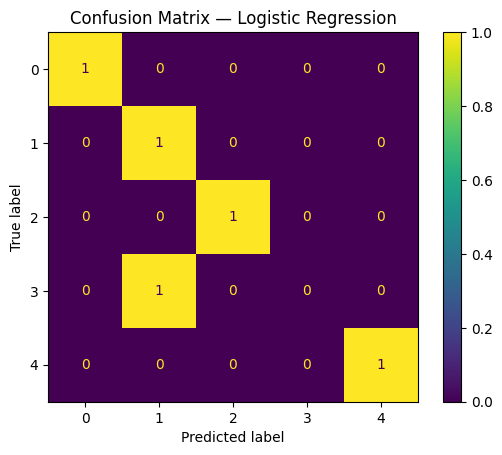


=== Decision Tree ===
Accuracy: 0.6000 | Macro-F1: 0.4667
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     1.0000    1.0000    1.0000         1
           2     0.5000    1.0000    0.6667         1
           3     0.5000    1.0000    0.6667         1
           4     0.0000    0.0000    0.0000         1

    accuracy                         0.6000         5
   macro avg     0.4000    0.6000    0.4667         5
weighted avg     0.4000    0.6000    0.4667         5



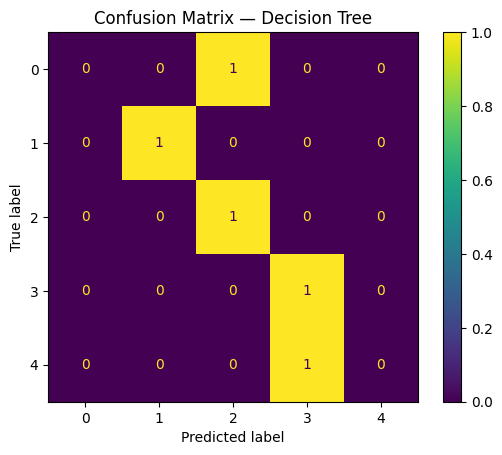


=== Random Forest ===
Accuracy: 0.4000 | Macro-F1: 0.2667
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.5000    1.0000    0.6667         1
           2     0.5000    1.0000    0.6667         1
           3     0.0000    0.0000    0.0000         1
           4     0.0000    0.0000    0.0000         1

    accuracy                         0.4000         5
   macro avg     0.2000    0.4000    0.2667         5
weighted avg     0.2000    0.4000    0.2667         5



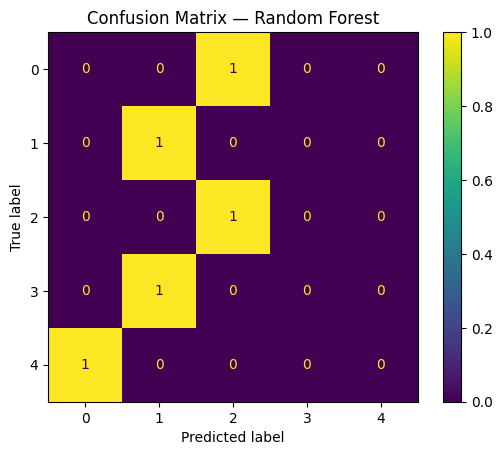


=== Naive Bayes (optional) ===
Accuracy: 0.8000 | Macro-F1: 0.7333
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         1
           1     0.5000    1.0000    0.6667         1
           2     1.0000    1.0000    1.0000         1
           3     0.0000    0.0000    0.0000         1
           4     1.0000    1.0000    1.0000         1

    accuracy                         0.8000         5
   macro avg     0.7000    0.8000    0.7333         5
weighted avg     0.7000    0.8000    0.7333         5



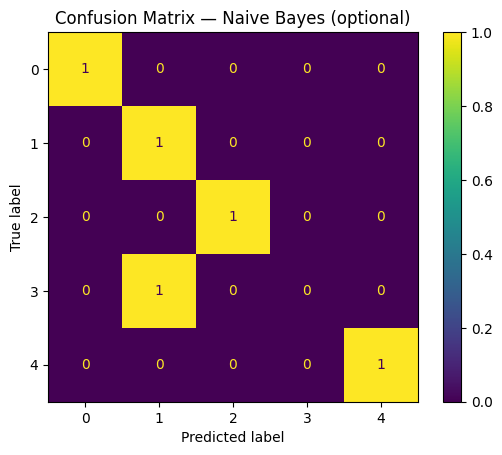

,Model,Accuracy,Macro_F1
0,Logistic Regression,0.8,0.733333
3,Naive Bayes (optional),0.8,0.733333
1,Decision Tree,0.6,0.466667
2,Random Forest,0.4,0.266667


In [38]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.naive_bayes import MultinomialNB

results = [
    fit_eval(LogisticRegression(max_iter=2000, n_jobs=-1, solver="saga", class_weight="balanced"), 
             "Logistic Regression"),
    fit_eval(DecisionTreeClassifier(random_state=42, max_depth=None, min_samples_leaf=2), 
             "Decision Tree"),
    fit_eval(RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1), 
             "Random Forest"),
    fit_eval(MultinomialNB(), 
             "Naive Bayes (optional)")
]
summary = pd.DataFrame([(n, a, f) for (n, a, f, _) in results],
                       columns=["Model", "Accuracy", "Macro_F1"]).sort_values("Macro_F1", ascending=False)
summary

In [39]:
# Select the best-performing model
best_name, best_acc, best_f1, best_clf = sorted(results, key=lambda x: x[2], reverse=True)[0]
print(f"✅ Best model: {best_name} | Acc={best_acc:.4f} | Macro-F1={best_f1:.4f}")


✅ Best model: Logistic Regression | Acc=0.8000 | Macro-F1=0.7333


In [40]:
def predict_topic(text_or_list):
    """Predict topic name and ID for one or multiple new complaints."""
    if isinstance(text_or_list, str):
        texts = [text_or_list]
    else:
        texts = list(text_or_list)
    
    X_counts_new = cv.transform(texts)
    X_tfidf_new  = tfidf_transformer.transform(X_counts_new)
    preds = best_clf.predict(X_tfidf_new)
    
    results = []
    for pid in preds:
        name = Topic_names.get(int(pid), str(pid))
        results.append((int(pid), name))
    
    return results

In [41]:
predict_topic([
    "They charged my credit card late fees twice.",
    "I need to report a fraudulent transaction.",
    "My mortgage payment wasn’t processed correctly."
])

[(1, 'Credit card or prepaid card'),
 (4, 'Others'),
 (0, 'Bank Account services')]